In [1]:
import numpy as np
import pandas as pd
# turning off chained assignment warnings.
pd.options.mode.chained_assignment = None  
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
from os.path import isfile, join
import sklearn.metrics
import os
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.cbook as cbook
import cv2
import imageio
from sklearn.linear_model import LinearRegression
import scipy as sp
from scipy.stats import chi2
from matplotlib import patches
import scipy.stats as stats

## Cells under defines functions needed for analysis

In [2]:


def sizeCompare(objectInformationList, imageFile):
    
    '''
    Creates a plot with different sized version of the image in the file, 
    image should be black with transparent background for best effect.
    The number of objects depends on the length of the objectInformationList
    
    
    Keyword arguments:
    objectInformationList --  list of dictionaries containing information of the version of 
                         the object to plot each dictionary should contain the following parameters 
                         {color: the color given as a RGBA value where each element ranges from 0 - 1,
                         width: width given as an float or integer,
                         height:height given as an float or integer,
                         label: label to write in legend
                         }
                         
    imageFile -- path to the image file 
    
    
    '''
    
    
    
    #reads image
    img = plt.imread(imageFile)
    
    #sets DPI to fixed value instead of relying on 72 being default value everywhere
    dpi = 72
    
    #get all the widths
    widths = [d["width"] for d in objectInformationList]
    
    #get avgWidth , last term is for dpi adjustment
    avgWidth = np.mean(widths) * (dpi / 72)
    
    #give padding of 0.25 average on both sides
    pixelWidth = 1.5 * avgWidth * len(objectInformationList) 
    
    xSpacing = 0.25 * avgWidth 
    
    fig_dims = ((pixelWidth / dpi), 4)
    
    #create figure
    fig, ax = plt.subplots(figsize = fig_dims , dpi = dpi)
    
    # gets highest yvalue
    yMax = max([d["height"] for d in objectInformationList ])
    
    #ylim is 10% higher than highest value
    yLim = yMax * 1.1

    ax.set_ylim((0, yLim))
    ax.set_xlim((0, pixelWidth))

    # get height and width of plot area
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    
    
    #Max number of pixels that can be plotted, this is the number of pixels yMax will get
    maxPix = (height * fig.dpi) / 1.1
    
    #holds information about where to place the net object on x axis
    xPlace = xSpacing
    
    #loops through all objects that is going to be plotted
    for tmpDict in objectInformationList:
        
        #gets info from the dict 
        tmpCol = tmpDict["color"]
        tmpWid = tmpDict["width"]
        tmpHeight = tmpDict["height"]
        
        #sets all non zero values to 1 and changes color 
        tmpImg = np.ceil(img)
        tmpImg[np.all(tmpImg == (0, 0, 0, 1 ), axis = - 1)] = tmpCol
        
        #resizes image
        tmpImg = cv2.resize(tmpImg, (int(tmpWid), int(maxPix * (tmpHeight / yMax))) )
        xPlace += tmpWid/2
    
        #draws image in figure 
        # zoom to handle dpi change
        imagebox = OffsetImage(tmpImg, zoom=72/dpi)
        ab = AnnotationBbox(imagebox, (xPlace, tmpHeight/2   ), frameon=False)
        ax.add_artist(ab)

        #new xplace     
        xPlace += tmpWid / 2 + xSpacing
        
    #after drawing all objects, draw lines outside of range for the figure to create a legend *Insert bigBrainMeme.jpg* 
    for tmpDict in objectInformationList:
        tmpCol = tmpDict["color"]
        tmpLabel = tmpDict["label"]
        
        plt.plot([xPlace + 1, xPlace + 2], [100, 100], label = tmpLabel, color = tmpCol)
    
    #set axes 
    ax.set_xlim((0,xPlace))
    
    #Want flat bottom line
    ax.set_xticks([xPlace + 1 ])
    ax.set_xticklabels("")
    
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_facecolor('none')
    
    return fig, ax

In [3]:

def multivariateGaussianMLE(data):
    '''
    Returns population mean and variance of a dataset 
    '''
    #mean
    mu = np.mean(data,axis = 0)
    
    #covariance
    diffs = data - mu
    dot = np.dot(diffs.T, diffs)
    sigma = dot/data.shape[0]
    
    return mu, sigma


In [4]:
def genVar(Data, grouping, nPointsFiltering, calcVars ):
    
    ''' 
    Groups by variables in grouping and calulates the mean and the generalized variance from the variables in calcVars.
    Generalized variance is calculated by taking the determinant of the covariance matrix for each group to get a 
    scalar value for the variance making it easier to compare how spread out different groups are. 
    '''
    
    #group data and count observations in each group
    groupedData = data.groupby(grouping)
    groupedData = groupedData["ID"].count()
    groupedData.name = "nDataPoints"

    #filter out the groupings which have to few observations
    filteredData = pd.merge(data,groupedData, left_on = grouping, right_on = grouping, how = "left")
    filteredData = filteredData[filteredData["nDataPoints"] > nPointsFiltering]
    filteredData = filteredData.groupby(grouping)

    #vectors to hold the results
    genVarVec = []
    countVec = []
    #loop over all groups, loop needed because need access to full group, agg wont work :(
    for name, group in filteredData:
        genVarVec.append( np.linalg.det( multivariateGaussianMLE( group[calcVars] )[1] ))
        countVec.append(group.shape[0])


    aggData = filteredData[calcVars].agg("mean")
    aggData = aggData.reset_index()
    retFrame = pd.concat([aggData,pd.DataFrame({"GenVec":genVarVec, "nObservations":countVec})], axis = 1)
    retFrame = retFrame.sort_values("GenVec",ascending = False)
    
    return retFrame

In [5]:

def findDiff(data ,grouping, nPointsFiltering, calcVars):
    '''
    Calculates the highest difference in calc vars using euclidean distance. 
    Filters by nPointsFiltering so that each group contains more than a certain number of observations.
    
    '''
    #groups data by grouping vector and counts number of obsercations in each group
    groupedData = data.groupby(grouping)
    groupedData = groupedData["ID"].count()
    groupedData.name = "nDataPoints"

    #filters data 
    filteredData = pd.merge(data,groupedData, left_on = grouping, right_on = grouping, how = "left")
    filteredData = filteredData[filteredData["nDataPoints"] > nPointsFiltering]
    filteredData = filteredData.groupby(grouping)


    # calculates the mean for each group and creates a distance matrix between groups
    aggData = filteredData[calcVars].agg("mean")
    distMat = sklearn.metrics.pairwise.euclidean_distances(aggData,aggData)
    
    
    #since argmax returns just one number, use // to get the rows and % to get the the column
    #and return the two rows with highest difference
    return aggData.iloc[[np.argmax(distMat) // distMat.shape[0], np.argmax(distMat) % distMat.shape[0] ],:]  

In [6]:

def diffInSport(data, grouping, nPointsFiltering, nYearsFiltering, calcVars):
    '''
    Finds the trend for each variable in calcVars over time for each grouping. 
    This is done by getting the trend as the slope of a linear regression for each variable. 
    Filters by number of observations in each group and number of years data is available for.
    
    '''
    
    #inserts year into grouping if it is not there
    if "Year" not in grouping:
        grouping.insert(0,"Year")
    
    #groups data and gets number of observations in each group
    groupedData = data.groupby(grouping)
    groupedData = groupedData["ID"].count()
    groupedData.name = "nDataPoints"

    #joins number of observations and filters data
    filteredData = pd.merge(data,groupedData, left_on = grouping, right_on = grouping, how = "left")
    filteredData = filteredData[filteredData["nDataPoints"] > nPointsFiltering]

    #Remove year from grouping
    grouping.remove("Year")
    
    #group by just number of years 
    groupedData = filteredData.groupby(grouping)
    groupedData = groupedData["Year"].nunique()
    groupedData.name = "nYears"

    #filter by number of year observations
    filteredData = pd.merge(data,groupedData, left_on = grouping, right_on = grouping, how = "left")
    filteredData = filteredData[filteredData["nYears"] > nYearsFiltering]
    
    # groups by grouping again, this time filtered by number of years observed.
    filteredData = filteredData.groupby(grouping)

    #dict to hold data, will become dataframe
    tmpDict = {}

    #goes over each group
    for name, group in filteredData:

        #calculates the trend as the slope for each variable in calcVar and inserts into Dict
        for var in calcVars:
            reg = LinearRegression().fit(group["Year"].values.reshape(-1, 1), group[var].values)
            if var not in tmpDict:
                tmpDict[var] = [reg.coef_[0]]
            else:
                tmpDict[var].append(reg.coef_[0])
        
        #inserts the event name into the tmpDict 
        if "Group" not in tmpDict:
            tmpDict["Group"] = [name]
        else:
            tmpDict["Group"].append(name)
            
    #creates a dataframe of the dict and returns it      
    retFrame = pd.DataFrame(tmpDict)
    
    #calculates the size of the vector describing the change 
    retFrame["ChangeSize"] = np.linalg.norm(retFrame[calcVars],axis = 1)
    
    retFrame = retFrame.sort_values("ChangeSize" , ascending = False)
    return retFrame

In [7]:
# function taken from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html


from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [8]:
def createGifFiles(data,outputFolder, events, nObs, hue = True):
    '''
    Creates files for Gif, run createGif to get the gif.
    '''

    tmpData = data[ ( data.Event.isin(events))]
    
    #if we want to compare winter and summer sports we need to shift winter olympics back 2 years after 1992
    #as they became split by then.
    tmpData.loc[(tmpData["Season"] == "Winter") & (tmpData["Year"] > 1992),tmpData.columns =="Year"] = \
        tmpData.loc[(tmpData["Season"] == "Winter") & (tmpData["Year"] > 1992),tmpData.columns =="Year"] - 2 

    years = tmpData.Year.unique()
    years.sort()
    
    #To have constant axises 
    minHeight = min(tmpData["Height"])
    maxHeight = max(tmpData["Height"])
    minWeight = min(tmpData["Weight"])
    maxWeight = max(tmpData["Weight"])
    
    # loops over all the years
    for year in years:
        counts = tmpData[(tmpData.Year == year)].groupby("Event")["ID"].count()
        #only want years when both events have over nObs observations
        if(len(counts) == len(events)) & np.all(counts > nObs):
            
            fig, ax = plt.subplots()
            
            if hue:
                sns.scatterplot(x = "Weight",y ="Height",hue = "Event", data=tmpData[(tmpData.Year == year)], hue_order = events)
            else:
                sns.scatterplot(x = "Weight",y ="Height", data=tmpData[(tmpData.Year == year)])

            ax.set_ylim(minHeight * 0.9, maxHeight * 1.1)
            ax.set_xlim(minWeight * 0.9, maxWeight * 1.1)
            
            ax.set_ylabel("Height (Cm)")
            ax.set_xlabel("Weight (Kg)")
            if hue:
                ax.legend(loc='center left', bbox_to_anchor=(0, 0.9))
            ax.title.set_text(year)

            plt.savefig(outputFolder+"/forGifFile" + str(year) +".png")
            plt.close()


In [9]:
def createGifFilesFull(data,outputFolder, events, nObs, hue = True):

    '''
    Similair to createGifFiles but with slight changes to 
    '''
    
    tmpData = data[ ( data.Event.isin(events))]
    
    #if we want to compare winter and summer sports we need to shift winter olympics back 2 years after 1992
    #as they became split by then.
    tmpData.loc[(tmpData["Season"] == "Winter") & (tmpData["Year"] > 1992),tmpData.columns =="Year"] = \
        tmpData.loc[(tmpData["Season"] == "Winter") & (tmpData["Year"] > 1992),tmpData.columns =="Year"] - 2 

    years = tmpData.Year.unique()
    years.sort()

    minHeight = min(tmpData["Height"])
    maxHeight = max(tmpData["Height"])
    minWeight = min(tmpData["Weight"])
    maxWeight = max(tmpData["Weight"])
    
    for year in years:
        fig, ax = plt.subplots(1,2, figsize = (8,6) , dpi = 72)
        
        #if there is no female data set a point outside of visible area so there is no crash when trying to remove legend.
        fData = tmpData[(tmpData.Sex == "F") & (tmpData["Year"] == year)]
        mData = tmpData[(tmpData.Sex == "M") & (tmpData["Year"] == year)]
        
        ax1  = sns.scatterplot(y = "Height" ,x = "Weight", hue = "Sport", alpha = 0.2, data = fData , ax=ax[0] )
        ax2  = sns.scatterplot(y = "Height" ,x = "Weight", hue = "Sport", alpha = 0.2, data = mData , ax=ax[1])



        #axes shuold be equal
        ax1.set_ylim((minHeight * 0.9 ,maxHeight * 1.1))
        ax2.set_ylim((minHeight * 0.9 ,maxHeight * 1.1))

        ax1.set_xlim((minWeight * 0.5 ,maxWeight * 1.1))
        ax2.set_xlim((minWeight * 0.5 ,maxWeight * 1.1))

        #legend will be very long, better to just remove
        # if there is not data there will be legend to remove so need to check that first
        
        if fData.shape[0] != 0 :
            ax1.get_legend().remove()
            
        if mData.shape[0] != 0 :   
            ax2.get_legend().remove()

        ax1.title.set_text("Female")
        ax2.title.set_text("Male")

        ax1.set_xlabel("Weight (Kg)")
        ax2.set_xlabel("Weight (Kg)")

        ax1.set_ylabel("Height (Cm)")
        ax2.set_ylabel("Height (Cm)")
        fig.tight_layout(pad=4)
        fig.suptitle("Height and weight of olympic athletes, split by gender \n " + str(year) +" Athletes: " + str(tmpData[(tmpData.Year == year)].shape[0]) + ", Events: " +str(len(tmpData[(tmpData.Year == year)]["Event"].unique())))
        plt.savefig(outputFolder+"/forGifFile" + str(year) +".png")
        plt.close()

In [10]:
def createGif(outputname,outputFolder, duration = 1):

    images = []
    for filename in os.listdir(outputFolder):
        images.append(imageio.imread(outputFolder + filename))

    imageio.mimsave(outputname + '.gif', images, duration = duration)

In [11]:
def plotSpreads(data, events, years, n_std=2 ):
    
    fig, ax = plt.subplots(figsize = (8,6))
    if not years is None:
        tmpData = data[ (data["Year"] == years[0]) & (data["Event"] == events[0]) ]
        ax.scatter(tmpData["Weight"], tmpData["Height"], s=2, alpha = 0.5, color = "blue", label = events[0] + " " + str(years[0]))
    else:
        tmpData = data[(data["Event"] == events[0]) ]
        ax.scatter(tmpData["Weight"], tmpData["Height"], s=2, alpha = 0.5, color = "blue", label = events[0])
    
    
    confidence_ellipse(tmpData["Weight"],tmpData["Height"],ax , edgecolor='blue' ,n_std = n_std)

    if not years is None:
        tmpData = data[ (data["Year"] == years[1]) & (data["Event"] == events[1]) ]
        ax.scatter(tmpData["Weight"], tmpData["Height"], s=2, alpha = 0.5, color = "orange", label = events[1] + " " + str(years[1]))

    else:
        tmpData = data[(data["Event"] == events[1])]
        ax.scatter(tmpData["Weight"], tmpData["Height"], s=2, alpha = 0.5, color = "orange", label = events[1])

    
    confidence_ellipse(tmpData["Weight"],tmpData["Height"],ax , edgecolor='orange', alpha = 0.5, n_std = n_std)
    
    ax.set_ylabel("Height (Cm)")
    ax.set_xlabel("Weight (Kg)")
    
    fig.legend(loc='center left', bbox_to_anchor=(0.13, 0.83))
    fig.suptitle('Spread of weight and height for athletes in different olympic sports \n Ellipses indicate ' + str(n_std) + ' standard deviations', fontsize = 16)
    plt.show()

In [12]:
def cleanData(data, analysisVars = ["Height","Weight"],
                  groupingVars = ["Year","Event"], idVar = "Name",
                 filterPercent = 0.5):
    
    #counts all rows to exclude as the rows that has NAs in oen of the analysis variables
    data["Exclude"] = np.sum(np.isnan(data[analysisVars]),axis=1) > 0
    
    #group by groupvariables and use the id var to couunt how many in each group and sums the number of excluded
    countExcluded = data.groupby(groupingVars)[[idVar,"Exclude"]].agg({idVar:"count","Exclude":sum}).reset_index()
    
    #Calculates the percentage of excluded rows due to having NAs
    countExcluded["percExcluded"] = countExcluded["Exclude"]/countExcluded[idVar]
    
    #inserts the percExcluded into the full data
    data = data.merge(countExcluded[groupingVars + ["percExcluded"]], left_on = groupingVars, right_on = groupingVars, how = "left" )
    
    #drops all rows that has NAs in the groupingVars and has over a certain percentage of excluded from the grouping
    data.dropna(subset = analysisVars , inplace = True)
    data = data[data["percExcluded"] < filterPercent]
    
    return data

In [13]:
#Define mahalanobis distance
def mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# EMPTY

# EMPTY

In [16]:
#reads data and drops observations which does not have age/weight
dataFile = "data_olympics/athlete_events.csv"
data = pd.read_csv(dataFile)


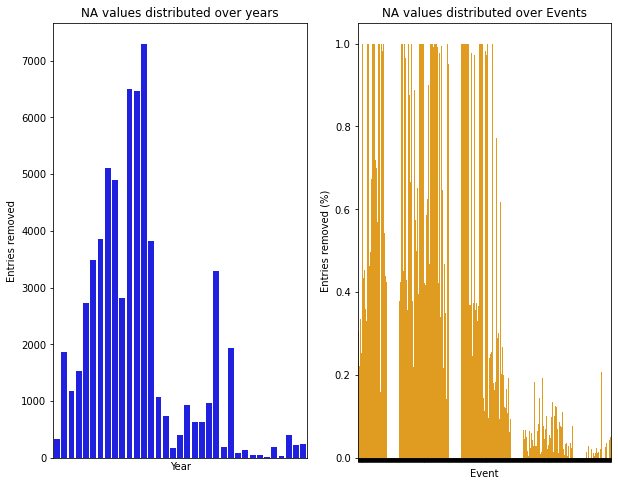

In [17]:
#Want to see where we are going to remove data 
data["Exclude"] = np.sum(np.isnan(data[["Height","Weight"]]),axis=1) > 0
countExcluded = data.groupby(["Year","Event"])[["Name","Exclude"]].agg({"Name":"count","Exclude":sum}).reset_index()

countExcluded["percExcluded"] = countExcluded["Exclude"]/countExcluded["Name"]

fig,ax = plt.subplots(1,2,figsize = (10,8))
ax0 = sns.barplot(x = "Year", y =  "Exclude", color="blue" , data = countExcluded ,ax = ax[0], ci = None, estimator=sum)
ax1 = sns.barplot(x = "Event", y =  "percExcluded", color="orange" , data = countExcluded, ax = ax[1], ci = None)


ax0.title.set_text("NA values distributed over years")
ax0.set_xticks([])
ax0.set_ylabel("Entries removed")
ax0.set_xlabel("Year")


ax1.axes.xaxis.set_ticklabels([])
ax1.title.set_text("NA values distributed over Events")

ax1.set_ylabel("Entries removed (%)")
plt.show()

In [18]:
data = cleanData(data)
print(data.shape)

(199196, 17)


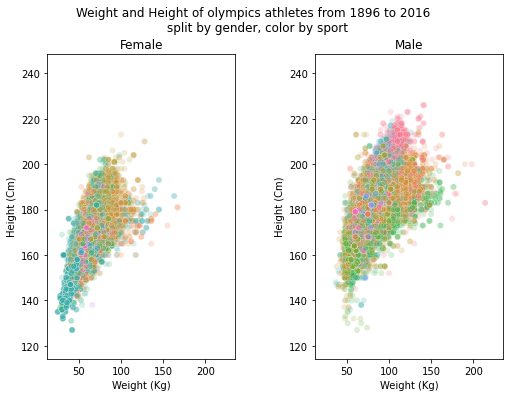

In [19]:
# plots full dataset split by male and female, color by sport
fig, ax = plt.subplots(1,2, figsize = (8,6) , dpi = 72)

ax1  = sns.scatterplot(y = "Height" ,x = "Weight", hue = "Sport", alpha = 0.2, data = data[data.Sex == "F"], ax=ax[0] )
ax2  = sns.scatterplot(y = "Height" ,x = "Weight", hue = "Sport", alpha = 0.2, data = data[data.Sex == "M"] , ax=ax[1])

#Full range of dataset
minHeight = min(data["Height"])
maxHeight = max(data["Height"])

minWeight = min(data["Weight"])
maxWeight = max(data["Weight"])

#axes shuold be equal
ax1.set_ylim((minHeight * 0.9 ,maxHeight * 1.1))
ax2.set_ylim((minHeight * 0.9 ,maxHeight * 1.1))

ax1.set_xlim((minWeight * 0.5 ,maxWeight * 1.1))
ax2.set_xlim((minWeight * 0.5 ,maxWeight * 1.1))

#legend will be very long, better to just remove
ax1.get_legend().remove()
ax2.get_legend().remove()

ax1.title.set_text("Female")
ax2.title.set_text("Male")

ax1.set_xlabel("Weight (Kg)")
ax2.set_xlabel("Weight (Kg)")

ax1.set_ylabel("Height (Cm)")
ax2.set_ylabel("Height (Cm)")
fig.tight_layout(pad=4)

fig.suptitle("Weight and Height of olympics athletes from 1896 to 2016 \n split by gender, color by sport")


plt.show()

In [21]:
#makes a gif of all data
allEvents = data["Event"].unique()
outputFolder = "fullGifFolder/"



# If folder doesn't exist, then create it.
if not os.path.isdir(outputFolder):
    os.makedirs(outputFolder)
    print("created folder : ", outputFolder)

else:
    print(outputFolder, "folder already exists.")



createGifFilesFull(data, outputFolder, allEvents, 0, hue = True)


createGif("gifs/fullgif",outputFolder,0.3)

created folder :  fullGifFolder/


![SegmentLocal](gifs/fullgif.gif "segment")

In [22]:
#creates grouping by event and sex
grouping = ["Event","Year"]

#Want to filter groups with over 10 observations
nPointsFiltering = 20

#use Height and Weight as variables to calculate difference by
calcVars = ["Height", "Weight"]
mData = data[data["Sex"] == "M"]
fData = data[data["Sex"] == "F"]

maleDiff = findDiff(mData ,grouping, nPointsFiltering, calcVars)
femaleDiff = findDiff(fData ,grouping, nPointsFiltering, calcVars)

maleDiff = maleDiff.sort_values("Height",ascending = False)
femaleDiff = femaleDiff.sort_values("Height",ascending = False)


print(maleDiff)
print(femaleDiff)

                                                Height      Weight
Event                                 Year                        
Weightlifting Men's Super-Heavyweight 2016  186.173913  140.304348
Boxing Men's Light-Flyweight          1976  159.666667   48.259259
                                             Height      Weight
Event                              Year                        
Judo Women's Heavyweight           2004  176.333333  112.166667
Gymnastics Women's Team All-Around 1980  151.750000   40.916667


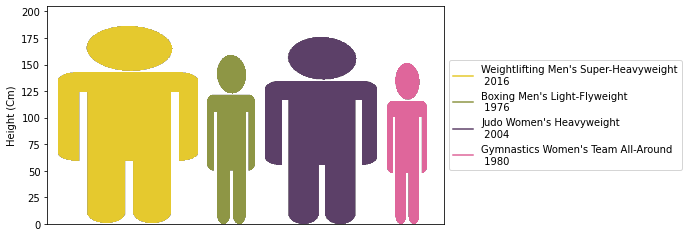

In [23]:
#there must be a better way to visualize 

#combine dataframes
combinedDiffs = pd.concat([maleDiff,femaleDiff])

#to hold to dictionaries defining the plot objects
plotDicts = []

#for every row 
for index, row in combinedDiffs.iterrows():
    plotDicts.append({"color" : np.concatenate([np.random.random(3),[1]]), 
       "width" : row["Weight"],
       "height" : row["Height"],
       "label" : index[0] +"\n "+ str(index[1])})

imgFile = "data_olympics/img.png"

fig, ax = sizeCompare(plotDicts,imgFile)

ax.set_ylabel("Height (Cm)")

plt.show()


#This is the average athletes of the events and years which have the biggest difference

In [24]:
display(combinedDiffs)

,,Height,Weight
Event,Year,,
Weightlifting Men's Super-Heavyweight,2016,186.173913,140.304348
Boxing Men's Light-Flyweight,1976,159.666667,48.259259
Judo Women's Heavyweight,2004,176.333333,112.166667
Gymnastics Women's Team All-Around,1980,151.750000,40.916667


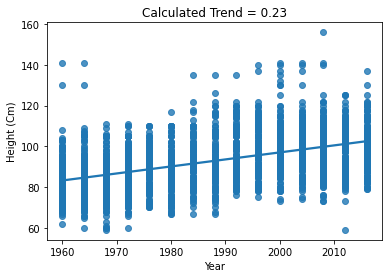

In [25]:
#First find a way to define how to see if the athletes have changed over time.
# One way is to find the trend for each variable by linear regression.

#this would look something like this
exampleFrame = data[data["Event"] == "Basketball Men's Basketball"]

reg = LinearRegression().fit(exampleFrame["Year"].values.reshape(-1, 1), exampleFrame["Height"].values)

fig, ax = plt.subplots()

sns.regplot(x = "Year", y = "Weight", data = exampleFrame, ci = None)

ax.set_ylabel("Height (Cm)")

ax.title.set_text("Calculated Trend = " +str(round(reg.coef_[0],2)))

plt.show()


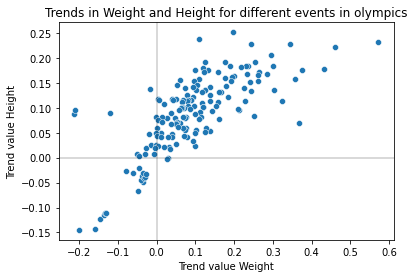

In [26]:
grouping = ["Event","Year"]
nPointsFiltering = 20
calcVars = ["Height","Weight"]
nYearsFiltering = 10

fig, ax = plt.subplots()

trendFrame = diffInSport(data, grouping, nPointsFiltering, nYearsFiltering, calcVars)

ax.axhline(0, color='black', alpha = 0.2)
ax.axvline(0, color='black', alpha = 0.2)

sns.scatterplot(x = "Weight"  , y = "Height" ,  data =  trendFrame)

ax.title.set_text("Trends in Weight and Height for different events in olympics")
ax.set_ylabel("Trend value Height")
ax.set_xlabel("Trend value Weight")


plt.show()

In [27]:
#want to get tod for each quadrant, skip quad2 as we can visualy see there is no event there
quad1 = trendFrame[(trendFrame["Weight"] >= 0) & (trendFrame["Height"] >= 0) ]
quad3 = trendFrame[(trendFrame["Weight"] < 0) & (trendFrame["Height"] < 0) ]
quad4 = trendFrame[(trendFrame["Weight"] < 0) & (trendFrame["Height"] >= 0) ]
display(quad1[:3])
display(quad3[:3])
display(quad4[:3])

,Height,Weight,Group,ChangeSize
122,0.232624,0.572873,Sailing Mixed Two Person Keelboat,0.618302
121,0.222290,0.460150,Sailing Mixed Three Person Keelboat,0.511029
47,0.177516,0.433177,Bobsleigh Men's Two,0.468139


,Height,Weight,Group,ChangeSize
99,-0.144905,-0.201373,Gymnastics Women's Horse Vault,0.248090
101,-0.143731,-0.159667,Gymnastics Women's Team All-Around,0.214831
100,-0.122690,-0.146970,Gymnastics Women's Individual All-Around,0.191450


,Height,Weight,Group,ChangeSize
127,0.088265,-0.213634,"Ski Jumping Men's Normal Hill, Individual",0.231150
126,0.094700,-0.210082,"Ski Jumping Men's Large Hill, Individual",0.230440
113,0.088443,-0.120243,Nordic Combined Men's Individual,0.149266


In [28]:
#use full dataset for gifs
gifData = pd.read_csv(dataFile)
gifData = cleanData(gifData,filterPercent = 1)

In [29]:
nObs = 5
outputFolder = "trendGifFolderLabels/"




# If folder doesn't exist, then create it.
if not os.path.isdir(outputFolder):
    os.makedirs(outputFolder)
    print("created folder : ", outputFolder)

else:
    print(outputFolder, "folder already exists.")
    
events = [quad1["Group"].values[0], quad3["Group"].values[0], quad4["Group"].values[0]]

createGifFiles(gifData,outputFolder, events, nObs, hue = True)
createGif("gifs/trendgiflabels",outputFolder,0.6)

created folder :  trendGifFolderLabels/


![SegmentLocal](gifs/trendgiflabels.gif "segment")

In [30]:
nObs = 5
outputFolder = "trendGifFolderNoLabels/"



# If folder doesn't exist, then create it.
if not os.path.isdir(outputFolder):
    os.makedirs(outputFolder)
    print("created folder : ", outputFolder)

else:
    print(outputFolder, "folder already exists.")
    
    
events = [quad1["Group"].values[0], quad3["Group"].values[0], quad4["Group"].values[0]]

createGifFiles(gifData,outputFolder, events, nObs, hue = False)
createGif("gifs/trendgifnolabels",outputFolder,0.6)

created folder :  trendGifFolderNoLabels/


![SegmentLocal](gifs/trendgifnolabels.gif "segment")

In [ ]:
# we might also be interested in which sports have the most homogenous group of athlets and which has the least.
# to do this we study the generalised variance. 

In [31]:
#decide groups 
grouping = ["Sex","Event", "Year"]
nPointsFiltering = 20
calcVars = ["Weight","Height"]


dataVar = genVar(data, grouping, nPointsFiltering, calcVars)


In [32]:
dataVar.sort_values("GenVec",ascending = False)

,Sex,Event,Year,Weight,Height,GenVec,nObservations
2703,M,Judo Men's Heavyweight,2012,128.774194,190.774194,25768.379074,31
2702,M,Judo Men's Heavyweight,2008,133.281250,191.156250,22258.407150,32
2701,M,Judo Men's Heavyweight,2004,123.757576,188.757576,15171.259531,33
2839,M,Rowing Men's Coxed Pairs,1984,76.750000,181.250000,14178.525077,36
3087,M,Shooting Men's Trap,2016,91.225806,180.354839,13677.578598,31
...,...,...,...,...,...,...,...
1959,M,Boxing Men's Light-Welterweight,2000,62.962963,173.000000,7.812884,27
1934,M,Boxing Men's Light-Heavyweight,2000,80.785714,183.714286,6.540087,28
1986,M,Boxing Men's Middleweight,2004,74.964286,181.214286,4.989887,28
1929,M,Boxing Men's Light-Flyweight,2016,48.954545,161.181818,1.017280,22


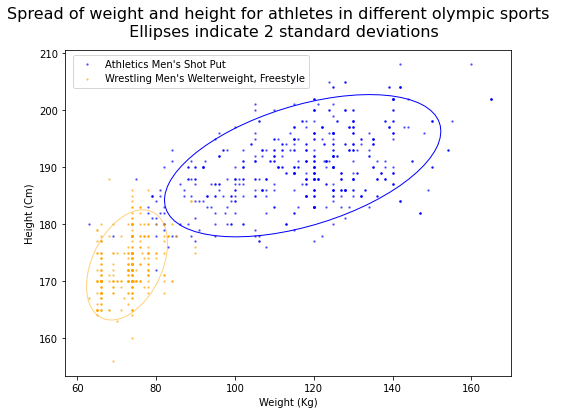

In [33]:
plotSpreads(data,["Athletics Men's Shot Put","Wrestling Men's Welterweight, Freestyle"],None)

In [34]:
#Byt ut nan till 'None'
data['Medal'] = data['Medal'].fillna('None')

In [35]:
#Mahalanobi distance grouped by Sex, Year and Sport
for sex in data['Sex'].sort_values().unique():
        sex_data = data[data['Sex'] == sex]
        
        for y in data['Year'].sort_values().unique():
            sex_year_data = sex_data[sex_data['Year'] == y]

            for event in data['Event'].sort_values().unique():
                event_data = sex_year_data[sex_year_data['Event'] == event]
                
                #If group less than 20: Skip
                if event_data.shape[0] <= 20:
                    pass

                    
                else:
                    #Check that inverse of cov is defined
                    try:
                        sp.linalg.inv(np.cov(event_data[['Height', 'Weight']].values.T))
                        
                    except: 
                        pass
                    
                    else:
                        data.loc[(data['Sex'] == sex)  & (data['Event'] == event) & (data['Year'] == y), 'mahalanobi'] = \
                            mahalanobis(event_data[['Height', 'Weight']], event_data[['Height', 'Weight']])

In [36]:
#Drop rows where mahalanobi was not calculated
data2 = data.dropna(subset=['mahalanobi'])


In [37]:
#Calculate p-values for mahalanobi
#2 dfs
data2['p-value'] = 1 - chi2.cdf(data2['mahalanobi'], 2)

In [38]:
#Define athletes with p-value < 0.05 as outliers 
if 'Outlier Group' in data2.columns:
        data2 = data2.drop(columns=['Outlier Group'])

outlier = pd.cut(data2['p-value'], bins= [0,0.05,1] , labels=['Outlier', 'Normal'])
data2.insert(0,'Outlier Group',outlier)

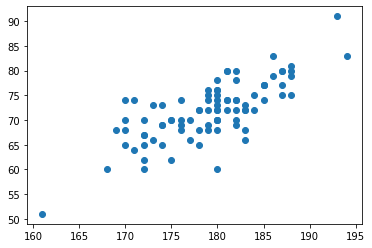

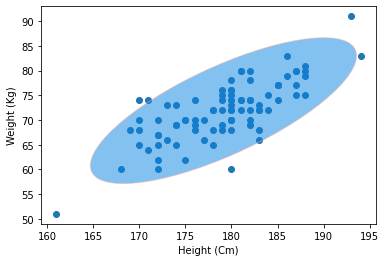

                                 Name  Height  Weight   p-value
120743              Mikhail Klecherov   161.0    51.0  0.001916
234162                 ukasz Szczurek   180.0    60.0  0.006579
88889              Simon Hallenbarter   193.0    91.0  0.006596
9938      Skinnar Per Tobias Arwidson   170.0    74.0  0.021279
68713   Bjrn Lars Johannes Erik Ferry   194.0    83.0  0.041620
39690   Vladimir Vitalyevich Chepelin   171.0    74.0  0.041837
225726                Jaroslav Soukup   183.0    66.0  0.066234


In [39]:
#Plot outliers

y = data2[data2['Year']==2014]
s = y[y['Sex']=='M']
#print(s['Event'].unique())
e = s[s['Event'] == "Biathlon Men's 20 kilometres"]
df = e[['Height', 'Weight']]
df = df.to_numpy()

plt.scatter(df[: , 0], df[ : , 1])

covariance = np.cov(df, rowvar=False)
covariance
centerpoint = np.mean(df , axis=0)
cutoff = chi2.ppf(0.95, df.shape[1])

pearson = covariance[0, 1]/np.sqrt(covariance[0, 0] * covariance[1, 1])
ell_radius_x = np.sqrt(1 + pearson)
ell_radius_y = np.sqrt(1 - pearson)
lambda_, v = np.linalg.eig(covariance)
lambda_ = np.sqrt(lambda_)

ellipse = patches.Ellipse(xy=(centerpoint[0], centerpoint[1]),
                  width=lambda_[0]*np.sqrt(cutoff)*2, height=lambda_[1]*np.sqrt(cutoff)*2,
                  angle=np.rad2deg(np.arccos(v[0, 0])), edgecolor='#fab1a0')


ellipse.set_facecolor('#0984e3')
ellipse.set_alpha(0.5)
fig = plt.figure()
ax = plt.subplot()
ax.add_artist(ellipse)
plt.scatter(df[: , 0], df[ : , 1])

ax.set_xlabel("Height (Cm)")
ax.set_ylabel("Weight (Kg)")


plt.show()

#Print relevent observations
print(e[['Name', 'Height', 'Weight', 'p-value']].sort_values('p-value', ascending = True).head(7))

In [40]:
#create column, medal_won. 1 if medal is won, 0 if not
data2.loc[:,'Medal_Won'] = 1
data2.loc[(data2['Medal'] == 'None'),'Medal_Won'] = 0

Text(0.5, 20.80000000000002, 'Medal')

<Figure size 576x576 with 0 Axes>

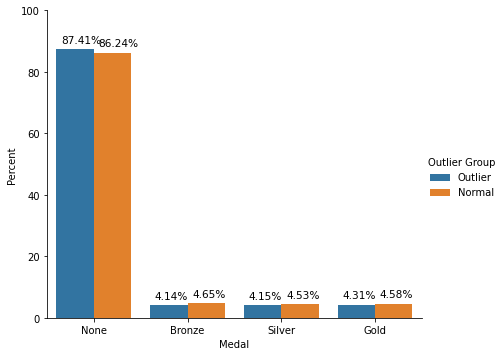

In [41]:
plt.figure(figsize=(8, 8))
#create barplot
g = (data2
.groupby('Outlier Group')['Medal']
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), height=5, aspect=1.2, x='Medal',y='percent',hue='Outlier Group',kind='bar', order=['None', 'Bronze','Silver','Gold']))

g.ax.set_ylim(0,100)

#add ellipse
for p in g.ax.patches:
    txt = str(p.get_height().round(2)) + '%'
    txt_x = p.get_x() 
    txt_y = p.get_height()
    g.ax.text(txt_x+0.05,txt_y+2,txt, fontsize = 10.5)

#change labels
g.ax.set_ylabel("Percent")
g.ax.set_xlabel("Medal")


In [42]:
##https://towardsdatascience.com/chi-square-test-with-python-d8ba98117626
#Test of independence

data_crosstab = pd.crosstab(data2['Outlier Group'] , data2['Medal'], margins=True, margins_name="Total")
#significance level
alpha = 0.05

# Calcualtion of Chisquare test statistics
chi_square = 0
rows = data2['Outlier Group'].unique()
columns = data2['Medal'].unique()
for i in columns:
    for j in rows:
        O = data_crosstab[i][j]
        E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
        chi_square += (O-E)**2/E

# The p-value approach
print("Approach 1: The p-value approach to hypothesis testing in the decision rule")
p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and p value is:", p_value)
print(conclusion)
    
# The critical value approach
print("\n--------------------------------------------------------------------------------------")
print("Approach 2: The critical value approach to hypothesis testing in the decision rule")
critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
conclusion = "Failed to reject the null hypothesis."
if chi_square > critical_value:
    conclusion = "Null Hypothesis is rejected."
        
print("chisquare-score is:", chi_square, " and critical value is:", critical_value)
print(conclusion)


Approach 1: The p-value approach to hypothesis testing in the decision rule
chisquare-score is: 11.222207359351456  and p value is: 1.1102230246251565e-16
Null Hypothesis is rejected.

--------------------------------------------------------------------------------------
Approach 2: The critical value approach to hypothesis testing in the decision rule
chisquare-score is: 11.222207359351456  and critical value is: 7.814727903251179
Null Hypothesis is rejected.


In [43]:
print(data_crosstab)

Medal          Bronze  Gold    None  Silver   Total
Outlier Group                                      
Outlier           404   421    8537     405    9767
Normal           8085  7958  149845    7864  173752
Total            8489  8379  158382    8269  183519
